# Mobility for resilience: population analysis

This notebook shows the preliminary steps done using `mobilkit` to load raw HFLB data, determine the population estimates of each area and prepare the data for displacement and POI visit rates.

We start loading raw HFLB data using the `mobilkit.loader` module.

In [1]:
%matplotlib inline
%config Completer.use_jedi = False

import os
import sys
from copy import copy, deepcopy
from glob import glob
from collections import Counter
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import pyproj
from scipy import stats
from sklearn import cluster

import dask
from dask.distributed import Client
from dask import dataframe as dd

### import mobility libraries
import skmob
import mobilkit

sns.set_context("notebook", font_scale=1.5)

In [10]:
dask.__version__ ### tested using Dask version 2020.12.0

'2020.12.0'

## Load data
### Set up Dask
* Notes:
    * Use **Dask** library for high-speed computation on edge computer
        * https://dask.org/
        * accumulates tasks and runs actual computation when ".compute()" is given
    * If cluster computing is available, using PySpark is recommended 
* Click the URL of the Dashboard below to monitor progress 

In [12]:
client = Client(address="127.0.0.1:8786") ### choose number of cores to use
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 28.00 GB


## Load raw data using `mobilkit` interface

In [16]:
datapath = "../../data/"
outpath  = "../../results/"

### define temporal cropping parameters (including these dates)
timezone = "America/Mexico_City"

startdate = "2017-09-04"
enddate   = "2017-10-08"

nightendtime = "09:00:00"
nightstarttime = "18:00:00"

# How to translate the original columns in the mobilkit's nomenclature
colnames = {"id": "uid",
            "gaid": "gaid",
            "hw": "hw",
            "lat": "lat",
            "lon": "lng",
            "accuracy": "acc",
            "unixtime": "UTC",
            "noise": "noise"
           }

# Wehere raw data are stored
filepath = "/data/DataWB/sample/*.part"
ddf = mobilkit.loader.load_raw_files(filepath,
                                     version="wb",
                                     sep=",",
                                     file_schema=colnames,
                                     start_date=startdate,
                                     stop_date=enddate,
                                     timezone=timezone,
                                     header=True,
                                     minAcc=300.,
                                    )

### Quickly compute min/max of space-time  

Use the `mobilkit` and `skmob` column names notations.

In [23]:
dmin, dmax, lonmin, lonmax, latmin, latmax = dask.compute(ddf.UTC.min(), 
                                                          ddf.UTC.max(), 
                                                          ddf.lng.min(), ddf.lng.max(), 
                                                          ddf.lat.min(), ddf.lat.max()
                                                         )

In [54]:
print(mobilkit.loader.fromunix2fulldate(dmin),
      mobilkit.loader.fromunix2fulldate(dmax))
print(lonmin, lonmax, latmin, latmax)

2017-09-03 10:07:17 2017-10-09 07:13:57
-105 -95 15.5 22.55


In [55]:
boundary = (lonmin, latmin, lonmax, latmax)

(-105, 15.5, -95, 22.55)

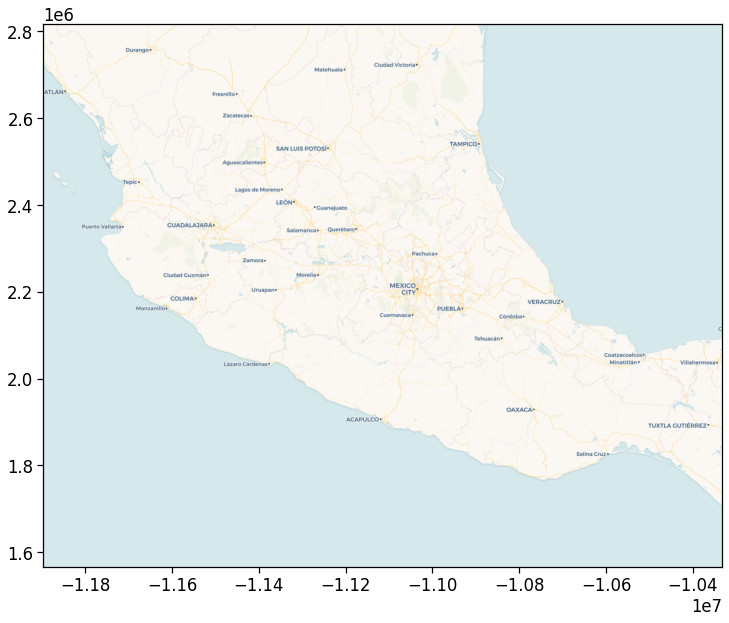

In [57]:
mobilkit.viz.visualize_boundarymap(boundary)

### Sample of dataset (choose a very small fraction) 

In [28]:
%%time
ddf_sample = ddf.sample(frac=0.0001).compute()

CPU times: user 11.9 s, sys: 736 ms, total: 12.6 s
Wall time: 5min 11s


In [29]:
len(ddf_sample)

32750

/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


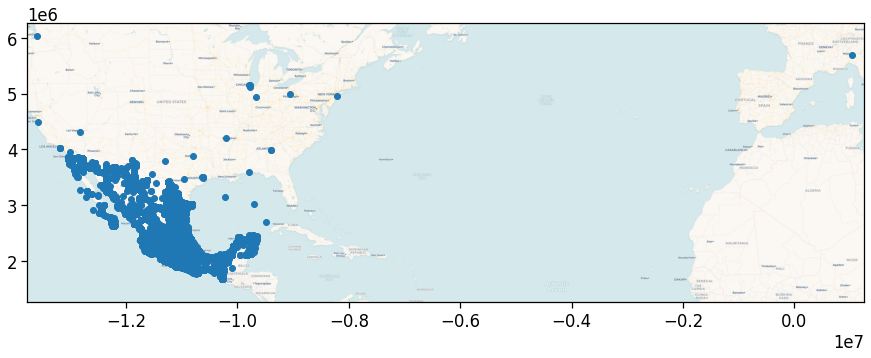

In [30]:
mobilkit.viz.visualize_simpleplot(ddf_sample)

## Clean data
* Some ideas on data cleaning:
    * **geographical boundary**; analyze data only within a specific area 
    * **temporal boundary**; analyze data only within a specific timeframe
    * **Users' data quality**; select users with more than X datapoints, etc.

### Geographical boundary 

In [31]:
### define boundary box: (min long, min lat, max long, max lat)
# ==== Parameters === #
bbox = (-106.3, 15.5, -86.3, 29.1)

In [32]:
# ddf_sc = ddf.map_partitions(data_preprocess.crop_spatial, bbox)
ddf_sc = ddf.map_partitions(mobilkit.loader.crop_spatial, bbox)

### Temporal boundary

These computation gets done automatically when loading now.

We only have to filter night hours.

In [34]:
nightendtime = "09:00:00"
nightstarttime = "18:00:00"

ddf_tc2 = ddf_sc.map_partitions(mobilkit.loader.crop_time,
                                nightendtime,
                                nightstarttime,
                                timezone)

### select users with sufficient data points
* **users_totalXpoints** : select users with more than X data points throughout entire period
* **users_Xdays** : select users with observations of more than X days
* **users_Xavgps** : select users with more than X observations per day 
* **users_Xdays_Xavgps** : select users that satisfy both criteria

In [38]:
# ==== Parameters === #
mindays = 3
avgpoints = 1

ddf = ddf.assign(uid=ddf["id"])
users_stats = mobilkit.stats.userStats(ddf).compute()
valid_users = set(users_stats[
                (users_stats["avg"] > avgpoints)
                & (users_stats["daysActive"] > mindays)
                ]["uid"].values)

ddf_clean = mobilkit.stats.filterUsersFromSet(ddf, valid_users)
# I do not have this col...
# ddf_clean_homework = ddf_clean[ddf_clean["hw"]=="HOMEWORK"]
# I keep only events during night
ddf_clean_homework = ddf_clean_homework[~ddf_clean_homework["datetime"].dt.hour.between(8,19)]

## Home location estimation

### Estimation using Meanshift
* took ~ 2 hours 15 minutes for entire dataset (mindays=1, avgpoints=0.1)

We compute home location and we later split it into its latitude and longitude.

---
**NOTE**

When determining the home location of a user, please consider that some data providers, like _Cuebiq_, obfuscate/obscure/alter the coordinates of the points falling near the user's home location in order to preserve privacy.

This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user's home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.

However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user's home location area. Please check if your data has such noise added and choose the spatial tessellation according to your use case.

---

In [42]:
id_home = ddf_clean_homework.groupby("uid").apply(mobilkit.spatial.meanshift)\
                                .compute()\
                                .reset_index()\
                                .rename(columns={0:"home"})
toc = datetime.now()
print("Number of IDs with estimated homes: ",len(id_home))

<ipython-input-42-2437fa6c87f0>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  id_home = ddf_clean_homework.groupby("uid").apply(mobilkit.spatial.meanshift)\
/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/distributed/worker.py:3445: UserWarning: Large object of size 19.15 MB detected in task graph: 
  (['a81dbcb8f4c35834d6619a45d67f34d95911fab1318710d ... e5ce12ca182'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Number of IDs with estimated homes:  279541


In [44]:
### save to csv file
id_home.to_csv("../data/"+"id_home_"+str(mindays)+"_"+str(avgpoints).replace(".","")+".csv")

In [46]:
id_home["lon"] = id_home["home"].apply(lambda x : x[0])
id_home["lat"] = id_home["home"].apply(lambda x : x[1])
id_home = id_home.drop(columns=["home"])[["uid","lon","lat"]]
id_home.lon = id_home.lon.astype("float64")
id_home.lat = id_home.lat.astype("float64")

In [48]:
# Create a geodataframe for spatial queries
idhome_gdf = gpd.GeoDataFrame(id_home, geometry=gpd.points_from_xy(id_home.lon, id_home.lat))

## Compute administrative region for each ID
### manzana shape data (for only urban areas) 

In [49]:
### load shape data
areas = ["09_Manzanas_INV2016_shp","17_Manzanas_INV2016_shp",
         "21_Manzanas_INV2016_shp","29_Manzanas_INV2016_shp"]
manz_shp = gpd.GeoDataFrame()
for i,a in enumerate(areas):
    manz_f = "data/spatial/manzanas_shapefiles/"+a+"/"
    manz_shp1 = gpd.read_file(manz_f)
    manz_shp = manz_shp.append(manz_shp1, ignore_index=True)
    print("done",i)

done 0
done 1
done 2
done 3


In [50]:
manz_shp = manz_shp[["geometry","CVEGEO",'ENT','MUN','LOC','AGEB', 'MZA']]
manz_shp.head()

,geometry,CVEGEO,ENT,MUN,LOC,AGEB,MZA
0,"POLYGON ((-99.20644 19.51393, -99.20640 19.513...",0900200010010001,09,002,0001,0010,001
1,"POLYGON ((-99.20594 19.51418, -99.20586 19.514...",0900200010010002,09,002,0001,0010,002
2,"POLYGON ((-99.20526 19.51279, -99.20526 19.512...",0900200010010003,09,002,0001,0010,003
3,"POLYGON ((-99.20563 19.51279, -99.20562 19.512...",0900200010010004,09,002,0001,0010,004
4,"POLYGON ((-99.20655 19.51278, -99.20653 19.512...",0900200010010005,09,002,0001,0010,005


### By Entidad or Municipio stratification

<AxesSubplot:>

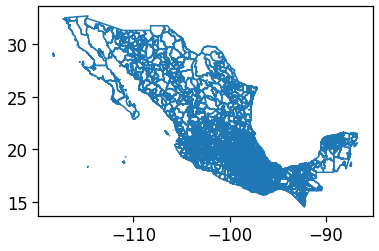

In [51]:
adm2_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm2_govmex/"
adm2_shp = gpd.read_file(adm2_f)
adm2_shp.boundary.plot()

In [52]:
adm2_shp = adm2_shp[["ADM2_PCODE","geometry"]]
adm2_shp["ent"] = adm2_shp["ADM2_PCODE"].apply(lambda x : x[2:4])
adm2_shp["entmun"] = adm2_shp["ADM2_PCODE"].apply(lambda x : x[2:])

In [53]:
adm2_shp.head()

,ADM2_PCODE,geometry,ent,entmun
0,MX01001,"POLYGON ((-102.09775 22.02325, -102.09857 22.0...",01,01001
1,MX01002,"POLYGON ((-101.99941 22.21951, -101.99940 22.2...",01,01002
2,MX01003,"POLYGON ((-102.57625 21.96778, -102.57626 21.9...",01,01003
3,MX01004,"POLYGON ((-102.25320 22.37449, -102.25239 22.3...",01,01004
4,MX01005,"POLYGON ((-102.31034 22.03716, -102.30653 22.0...",01,01005


### Spatial join with manzana data
* compute what geographical boundar each home location is in

In [2]:
id_manz = gpd.sjoin(idhome_gdf, manz_shp, how="inner", op='within')
id_manz["loc_code"]  = id_manz["CVEGEO"].apply(lambda x : x[:9])
id_manz["ageb_code"] = id_manz["CVEGEO"].apply(lambda x : x[:13])
id_manz["mza_code"]  = id_manz["CVEGEO"].apply(lambda x : x[:16])
id_manz = id_manz.drop(columns=["LOC","AGEB","MZA"])

### Spatial join with entidad/muncipio data

In [3]:
id_entmun = gpd.sjoin(idhome_gdf, adm2_shp, how="inner", op='within')

## Validation using census population data
### Population data for all levels

In [56]:
poppath = datapath+"sociodemographic/populationdata/"
df_pop = pd.DataFrame()
for es in ["09","17","21","29"]:
    pop = poppath+"resultados_ageb_urbana_"+es+"_cpv2010.csv"
    df_pop1 = pd.read_csv(pop)[["entidad","mun","loc","ageb","mza","pobtot"]]
    df_pop = df_pop.append(df_pop1, ignore_index=True)
    
df_pop["CVEGEO"] = df_pop.apply(lambda row: str(row["entidad"]).zfill(2)+
                                str(row["mun"]).zfill(3)+
                                str(row["loc"]).zfill(4)+
                                str(row["ageb"]).zfill(4)+
                                str(row["mza"]).zfill(3), axis=1)

In [57]:
df_pop.head()

,entidad,mun,loc,ageb,mza,pobtot,CVEGEO
0,9,0,0,0000,0,8851080,0900000000000000
1,9,2,0,0000,0,414711,0900200000000000
2,9,2,1,0000,0,414711,0900200010000000
3,9,2,1,0010,0,3424,0900200010010000
4,9,2,1,0010,1,202,0900200010010001


### Entidad level

In [59]:
ent_ids = id_entmun.groupby("ent").uid.count().reset_index()
ent_pop = df_pop[(df_pop["mun"]==0) & (df_pop["loc"]==0) 
                 & (df_pop["ageb"]=="0000") & (df_pop["mza"]==0)][["entidad","pobtot"]]
ent_pop["ent"] = ent_pop["entidad"].apply(lambda x : str(x).zfill(2))
ent_ids_pop = ent_pop.merge(ent_ids, on="ent")

### Municipio level

In [60]:
mun_ids = id_entmun.groupby("entmun").uid.count().reset_index()
mun_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]==0) 
                 & (df_pop["ageb"]=="0000") & (df_pop["mza"]==0)][["CVEGEO","pobtot"]]
mun_pop["entmun"] = mun_pop["CVEGEO"].apply(lambda x : str(x)[:5])
mun_ids_pop = mun_pop.merge(mun_ids, on="entmun")

### Localidades level

In [61]:
loc_ids = id_manz.groupby("loc_code").uid.count().reset_index()
loc_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]!=0) 
                 & (df_pop["ageb"]=="0000") & (df_pop["mza"]==0)][["CVEGEO","pobtot"]]
loc_pop["loc_code"] = loc_pop["CVEGEO"].apply(lambda x : str(x)[:9])
loc_ids_pop = loc_pop.merge(loc_ids, on="loc_code")

### AGEB level

In [62]:
ageb_ids = id_manz.groupby("ageb_code").uid.count().reset_index()
ageb_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]!=0) 
                 & (df_pop["ageb"]!="0000") & (df_pop["mza"]==0)][["CVEGEO","pobtot"]]
ageb_pop["ageb_code"] = ageb_pop["CVEGEO"].apply(lambda x : str(x)[:13])
ageb_ids_pop = ageb_pop.merge(ageb_ids, on="ageb_code")

### Manzana level

In [63]:
mza_ids = id_manz.groupby("mza_code").uid.count().reset_index()
mza_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]!=0) 
                 & (df_pop["ageb"]!="0000") & (df_pop["mza"]!=0)][["CVEGEO","pobtot"]]
mza_pop["mza_code"] = mza_pop["CVEGEO"].apply(lambda x : str(x)[:17])
mza_ids_pop = mza_pop.merge(mza_ids, on="mza_code")

## Plot census population vs MP data

In [64]:
def plot_compare(df, ax, title):
    df["logpop"] = np.log10(df["pobtot"])
    df["loguser"] = np.log10(df["uid"])        
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
#     for col in set(df["color"].values):
#         df_thiscol = df[df["color"]==col]
    ax.scatter(df["logpop"].values, df["loguser"].values, color="b", s=15)
    c1, i1, s1, p_value, std_err = stats.linregress(df["logpop"].values, df["loguser"].values)
    ax.plot([0,np.max(df["logpop"])*1.1],[i1,i1+np.max(df["logpop"])*1.1*c1], 
            linestyle="-", color="gray")   
    ax.set_xlim(np.min(df["logpop"]),np.max(df["logpop"])*1.1)
    ax.set_ylim(0,np.max(df["loguser"])*1.1)
    ax.set_xlabel(r"$log_{10}$(Census population)", fontsize=14)
    ax.set_ylabel(r"$log_{10}$(Unique users)", fontsize=14)
    ax.annotate("Slope: "+str(c1)[:5]+"\n"+str(s1)[:5], #+utils.stars(p_value), 
                        xy=(.1,0.7), 
                        xycoords='axes fraction', color="k", fontsize=14)
    ax.set_title(title, fontsize=16)

/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


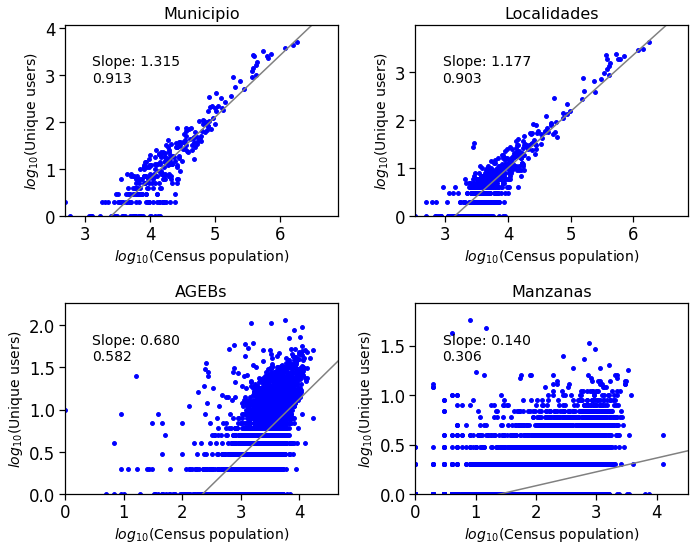

In [65]:
fig = plt.figure(figsize=(10,8))
gs=GridSpec(2,2)

ax0 = fig.add_subplot(gs[0,0]) 
plot_compare(mun_ids_pop, ax0, "Municipio")

ax1 = fig.add_subplot(gs[0,1]) 
plot_compare(loc_ids_pop, ax1, "Localidades")

ax2 = fig.add_subplot(gs[1,0]) 
plot_compare(ageb_ids_pop, ax2, "AGEBs")

ax3 = fig.add_subplot(gs[1,1]) 
plot_compare(mza_ids_pop, ax3, "Manzanas")

plt.tight_layout()
# plt.savefig(outpath+"represent_manzana_eq.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## Plot population on map

In [66]:
mun_ids_pop["rate"] = mun_ids_pop["uid"]/mun_ids_pop["pobtot"]
mun_ids_pop["pcode"] = mun_ids_pop["entmun"].apply(lambda x : "MX"+str(x))

mun_ids_pop_shp = adm2_shp.merge(mun_ids_pop, on="entmun", how="right")

<AxesSubplot:>

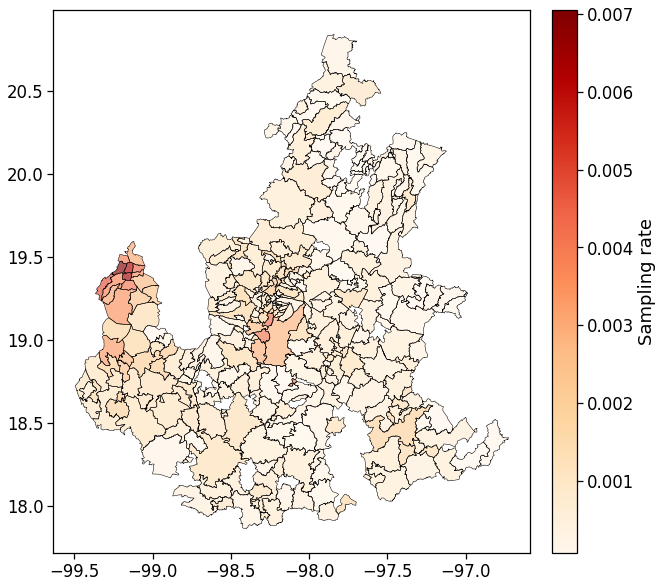

In [68]:
fig,ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mun_ids_pop_shp.plot(ax=ax, column='rate', cmap='OrRd', legend=True, 
                    cax=cax, legend_kwds={'label': "Sampling rate"}, alpha=0.65)
mun_ids_pop_shp.boundary.plot(ax=ax, color="k", linewidth=0.5)